In [1]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision, torchaudio
import torch.optim as optim
import scipy as sp
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [2]:
%cd ..

/home/gatanasio/SSPT_IMU


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
root_dir = os.path.join('/data2', 'WEAR')
'''
Annotations:
    - wear_split_1.json
    - wear_split_2.json
    - wear_split_3.json
'''
annotations_dir = os.path.join(root_dir, 'annotations')
inertial_dir = os.path.join(root_dir, 'raw', 'inertial')
annotations_file = 'wear_split_1.json'

train = True

In [4]:
df_ann1 = pd.read_json(os.path.join(annotations_dir, annotations_file))
df_ann2 = pd.read_json(os.path.join(annotations_dir, 'wear_split_2.json'))
df_ann3 = pd.read_json(os.path.join(annotations_dir, 'wear_split_3.json'))


In [ ]:
len(df_ann1), len(df_ann2), len(df_ann3)

In [ ]:
df_ann1

In [ ]:
df_ann2

In [ ]:
df_ann3

In [ ]:
labels = df_ann1[df_ann1['label_dict'].notna()]
labels = labels.drop(columns=['version', 'database'])
labels

In [ ]:
df_clean_split = pd.DataFrame(columns=['file', 'label', 'split'])

In [ ]:
src_dir = os.path.join('data', 'WEAR', 'annotations')
cls_file = 'wear_cls.pkl'
os.makedirs(src_dir, exist_ok=True)
pd.to_pickle(labels, os.path.join(src_dir, cls_file))

In [ ]:
df = df_ann1['database'].iloc[0]
df = pd.DataFrame(df)

In [ ]:
df

In [ ]:
df.query('subset == "Training"')

In [ ]:
df.loc[0, 'annotations']

# Splits creation

In [5]:
def prepare_df(df):
    df_start = df[df['label_dict'].isna()].drop(columns=['version', 'label_dict'])
    df_start['sbj_id'] = df_start.index
    df_start.reset_index(drop=True, inplace=True)
    return df_start

In [6]:
def extract_annotations(df):
    df_refactored = pd.DataFrame(columns=['sbj_id', 'subset', 'label_id', 'start_s', 'stop_s', 'start_frame', 'stop_frame'])
    
    df = prepare_df(df)

    for idx, row in df.iterrows():
        sbj_id = row['sbj_id']
        database = pd.DataFrame(row['database'])
        new_cols = {
            'start_s': database['annotations'].apply(lambda x: x['segment'][0]),
            'stop_s': database['annotations'].apply(lambda x: x['segment'][1]),
            'start_frame': database['annotations'].apply(lambda x: x['segment (frames)'][0]),
            'stop_frame': database['annotations'].apply(lambda x: x['segment (frames)'][1]),
            'label_id': database['annotations'].apply(lambda x: x['label_id'])
        }
        database = database.assign(**new_cols)
        database['sbj_id'] = sbj_id
        database = database.drop(columns=['annotations', 'fps'])
        df_refactored = pd.concat([df_refactored, database])

    df_refactored.reset_index(drop=True, inplace=True)
    return df_refactored

In [7]:
df_ann1_new = extract_annotations(df_ann1)
df_ann2_new = extract_annotations(df_ann2)
df_ann3_new = extract_annotations(df_ann3)

/tmp/ipykernel_1761805/2257380593.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_refactored = pd.concat([df_refactored, database])
/tmp/ipykernel_1761805/2257380593.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_refactored = pd.concat([df_refactored, database])
/tmp/ipykernel_1761805/2257380593.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when de

In [ ]:
df_ann1_new

In [9]:
src_dir = os.path.join('data', 'WEAR', 'annotations')
df_ann1_new.to_pickle(os.path.join(src_dir, 'crossval_refactored', 'wear_split_1.pkl'))
df_ann2_new.to_pickle(os.path.join(src_dir, 'crossval_refactored', 'wear_split_2.pkl'))
df_ann3_new.to_pickle(os.path.join(src_dir, 'crossval_refactored', 'wear_split_3.pkl'))

In [5]:
filename_refactored = 'wear_annotations_refactored.pkl'
pd.to_pickle(df_new, os.path.join(src_dir, filename_refactored))

NameError: name 'df_new' is not defined

In [ ]:
# create training split
df_tmp = df_new
df_tmp['sbj_id'][df_tmp['subset']=='Validation'].unique()

In [ ]:
for sbj_id in ['sbj_0', 'sbj_1', 'sbj_2']:
    df_tmp.loc[df_tmp['sbj_id']==sbj_id, 'subset'] = 'Training'

In [ ]:
df_train = df_tmp[df_tmp['subset']=='Training'].drop(columns=['subset'])
df_val = df_tmp[df_tmp['subset']=='Validation'].drop(columns=['subset'])

In [ ]:
pd.to_pickle(df_train, os.path.join(src_dir, 'wear_annotations_refactored_train.pkl'))
pd.to_pickle(df_val, os.path.join(src_dir, 'wear_annotations_refactored_val.pkl'))

In [ ]:
f'# Training: {len(df_train)}, #Validation: {len(df_val)}'

In [ ]:
df_train

In [ ]:
sbj_duration = df_train[['sbj_id', 'duration']]

In [ ]:
len(df_train[['sbj_id', 'duration']].drop_duplicates())

In [ ]:
df_train['sbj_id', 'duration'].unique()

# Data Visualization

In [5]:

annotations_dir = os.path.join('data', 'WEAR', 'annotations')
annotations_file = 'wear_annotations_refactored.pkl'
df_ann = pd.read_pickle(os.path.join(annotations_dir, annotations_file))

In [6]:
df_ann[df_ann['subset']=='Training'].sbj_id.value_counts()

sbj_id
sbj_10    40
sbj_13    38
sbj_17    34
sbj_12    32
sbj_14    31
sbj_7     29
sbj_6     27
sbj_16    26
sbj_9     24
sbj_8     23
sbj_15    22
sbj_11    20
Name: count, dtype: int64

In [ ]:
df_ann.keys()

In [ ]:
df_ann['start_s']

In [ ]:
durations = df_ann['stop_s'] - df_ann['start_s']
max_duration = durations.max()
bin_width = 1 #seconds
bins = list(range(0, int(max_duration) + 1, int(bin_width)))
durations.sort_values().plot(kind='hist', bins=bins, density=True, title='Duration of the training set videos')

# Considerazioni
Gli split 1, 2 e 3 sono la stessa cosa, ma cambiano nel tipo 'training-validation' per fare un 3-fold.

# Feature extraction - IMU

In [5]:
imu_file = 'sbj_10.csv'
sample_rate = 50 #Hz, source
downsampling_rate = 50 #Hz, target
wsize = 5 #seconds
woverlap = 2.5 #seconds


In [6]:
sensors = pd.read_csv(os.path.join(inertial_dir, imu_file))
sensors = sensors.drop(columns=['label'])
sensors

,sbj_id,right_arm_acc_x,right_arm_acc_y,right_arm_acc_z,right_leg_acc_x,right_leg_acc_y,right_leg_acc_z,left_leg_acc_x,left_leg_acc_y,left_leg_acc_z,left_arm_acc_x,left_arm_acc_y,left_arm_acc_z
0,10,0.981982,0.371020,0.025510,0.988918,0.065501,0.148098,0.982915,-0.083130,0.021120,-0.950163,0.274206,0.111081
1,10,0.983750,0.345706,-0.010884,0.990056,0.064240,0.149030,0.987285,-0.079543,0.018310,-0.955690,0.279296,0.099610
2,10,0.971634,0.340019,-0.030786,0.989048,0.064956,0.147591,0.992469,-0.082871,0.015696,-0.961587,0.284993,0.094157
3,10,0.958144,0.354297,-0.030645,0.988378,0.068118,0.146044,0.993909,-0.085662,0.013044,-0.965589,0.289072,0.089787
4,10,0.957273,0.373711,-0.021169,0.990330,0.070336,0.146870,0.990640,-0.088543,0.017493,-0.966240,0.291954,0.085833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199245,10,0.893520,-0.358096,-0.841556,0.443600,-0.568360,1.082030,0.932721,-0.029403,0.479873,-0.994943,0.025287,-0.149729
199246,10,0.890451,-0.281284,-0.788299,0.352229,-0.708798,0.813478,0.880057,-0.023242,0.485883,-1.018028,0.119410,-0.202391
199247,10,0.941280,-0.182932,-0.720960,0.252565,-0.903455,0.553040,0.833505,0.025358,0.484819,-1.054722,0.070287,-0.196611
199248,10,1.004967,-0.166500,-0.824787,0.192560,-0.903387,0.544455,0.906807,0.048203,0.411519,-1.099370,0.011230,-0.173830


In [7]:
sensors.isna().any()

sbj_id             False
right_arm_acc_x    False
right_arm_acc_y    False
right_arm_acc_z    False
right_leg_acc_x    False
right_leg_acc_y    False
right_leg_acc_z    False
left_leg_acc_x     False
left_leg_acc_y     False
left_leg_acc_z     False
left_arm_acc_x      True
left_arm_acc_y      True
left_arm_acc_z      True
dtype: bool

In [8]:
right_arm_acc = sensors[['right_arm_acc_x', 'right_arm_acc_y', 'right_arm_acc_z']]
right_arm_acc = torch.tensor(right_arm_acc.values.T, dtype=torch.float32)
right_arm_acc.shape

torch.Size([3, 199250])

In [9]:
import librosa

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_frames = waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr

    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

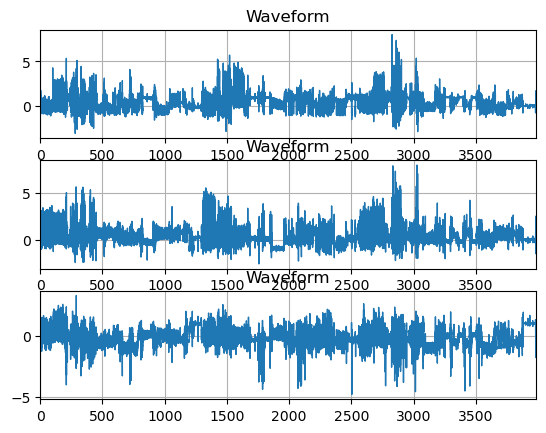

In [10]:
fig, axs = plt.subplots(3,1)
plot_waveform(right_arm_acc[0, :], sample_rate, ax=axs[0])
plot_waveform(right_arm_acc[1, :], sample_rate, ax=axs[1])
plot_waveform(right_arm_acc[2, :], sample_rate, ax=axs[2])
plt.show()

In [ ]:
accl_fft = torch.fft.fft(
    right_arm_acc,
    dim=1,
)

In [ ]:
def plot_fft(accl_fft):
    # Plotting the real part of accl_fft
    plt.plot(accl_fft.real)
    plt.xlabel('f (Hz)')
    plt.ylabel('|fft(X)|')
    plt.title('Real part of accl_fft')
    plt.show()


In [ ]:
fs = sample_rate
fc = 5  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = sp.signal.butter(5, w, 'low')
output = sp.signal.filtfilt(b, a, right_arm_acc[0].numpy())
plt.plot(output, label='filtered')
plt.legend()
plt.show()

In [ ]:
right_arm_acc_x_filtered = torch.from_numpy(np.float32(output).copy())
right_arm_acc_x_filtered.shape

In [ ]:
right_arm_acc_x_filtered.dtype

In [ ]:
resampled = T.Resample(sample_rate, downsampling_rate)(right_arm_acc_x_filtered)
accl_fft = torch.fft.fft(
    resampled
)
plot_fft(accl_fft)

# Spectrogram

In [11]:
def normalize_tensor(tensor):
    tensor = torch.from_numpy(tensor)
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

def cut_and_pad(signal, sampling_rate, seconds):
    padded_signal = torch.zeros(sampling_rate * seconds)
    if signal.shape[0] < sampling_rate * seconds:
        padded_signal = torch.zeros(sampling_rate * seconds)
        padded_signal[:signal.shape[0]] = signal
    else:
        padded_signal = signal[:sampling_rate * seconds]

    return padded_signal

In [42]:
focus = 1000
sec = 2 #FIXME: con 2 e 5 secondi non funziona
downsampling_rate = 50 # 25
prova_2s = right_arm_acc[:, focus:focus + int(sample_rate * sec)]
prova_2s = torchaudio.functional.resample(prova_2s, sample_rate, sample_rate)
# prova_2s = accl_x_interp_torch
# prova_2s = normalize_tensor(prova_2s.numpy())
# 

# n_ffts = [32, 64, 128, 256]
n_ffts = [256]
hop_length = [2, 4, 8, 16]

specs = []
for i, n_fft in enumerate(n_ffts):
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=24,
        hop_length=1,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
    )
    spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = spectrogram(prova_2s)
    prova = librosa.power_to_db(prova)
    # prova = normalize_tensor(prova)
    specs.append(prova)

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (128, 128) at dimension 2 of input [1, 3, 100]

In [56]:
waveform = prova_2s
spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=256, 
            win_length=24,
            hop_length=1, 
            # window_fn=torch.hann_window 
        )

Fs = 50
resample_ratio = 320/waveform.shape[1]
resample_target = int(Fs*resample_ratio)
waveform = torchaudio.transforms.Resample(50, resample_target)(waveform)
spectrogram = spectrogram_transform(waveform) # from [1,320] to [1,129,321]
spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)
fbank = spectrogram_db.squeeze(0).transpose(0,1)[:,:128]

In [41]:
resample_ratio

3.2

In [54]:
spectrogram_db.shape

torch.Size([3, 129, 321])

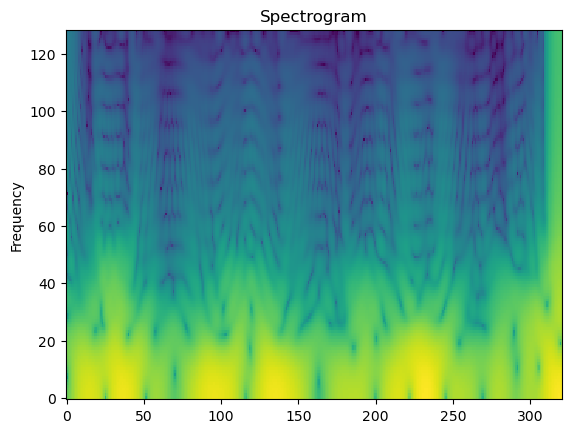

In [57]:
plot_spectrogram(spectrogram_db[0], title='Spectrogram', ylabel='Frequency', ax=None)

In [22]:
for i in range(len(specs)):
    print(specs[i].shape) 

(3, 17, 51)
(3, 33, 51)
(3, 65, 51)


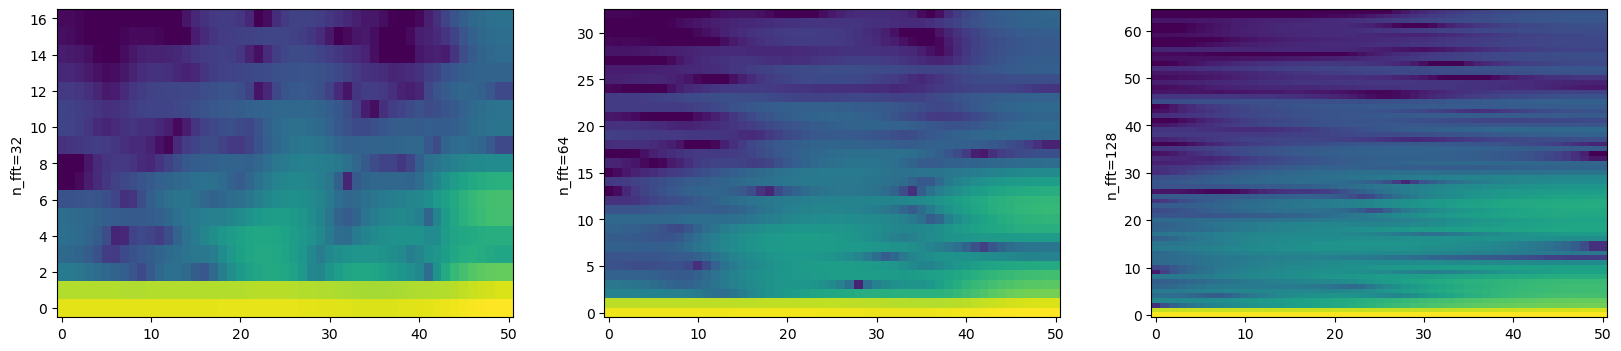

In [23]:
fig, axs = plt.subplots(1, len(specs), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)

In [ ]:
resized_spec = torchvision.transforms.Resize((64, 64))(torch.tensor(specs[2]))

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plot_spectrogram(resized_spec[0], ylabel=f"{n_ffts[2]=}", ax=axs)

# Mel Spectrogram

In [ ]:
n_ffts = [32, 64, 128, 256]
hop_length = [2, 4, 8, 16]
downsampling_rate = sample_rate
specs_mel = []
for i, n_fft in enumerate(n_ffts):
    mel_spectrogram = T.MelSpectrogram(
        n_mels=25,
        sample_rate=downsampling_rate,
        n_fft=n_fft,
        hop_length=4,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
    )
    mel_spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = mel_spectrogram(prova_2s)
    prova = librosa.power_to_db(prova)
    prova = normalize_tensor(prova)
    specs_mel.append(prova)

In [ ]:
for spec in specs_mel:
    print(spec.shape)

In [ ]:
fig, axs = plt.subplots(1, len(specs_mel), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs_mel, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

# SSL split

Create annotations for SSL split

- window = 10 s
- overlap = 50%

In [ ]:
annotations_ssl_wear = 'annotations_ssl_wear.pkl'

df_ssl_wear = pd.DataFrame(columns=[
    'subject',
    'start_s',
    'stop_s'
])

In [ ]:
aux = {}

for i, row in df_ann1.iterrows():
    
    if  i.startswith('sbj') and (i not in aux) and (row['database']['subset'] == 'Training'):
        print(i, row['database']['subset'])
        aux[i] = {
            'duration_s': row['database']['duration']
        }


In [ ]:
aux

In [ ]:
overlap_in_s = 5
window_size = 10
sampling_rate_accl = 50

for i, row in aux.items():
    duration = row['duration_s']
    n_windows = int((duration * (window_size / overlap_in_s)) / window_size)

    print(f'{i=}, {n_windows=}')

    for j in range(n_windows):
        start = j * overlap_in_s
        stop = start + window_size

        df_ssl_wear.loc[len(df_ssl_wear.index)] = [i, start, stop]
df_ssl_wear

In [ ]:
len(df_ssl_wear.query('subject == "sbj_6"'))